# Desafio Data Science Intelivix
***
Por: [Paulo Romeira](https://github.com/pauloromeira)  
paulo@pauloromeira.com

Acesse o [nbviewer](https://nbviewer.jupyter.org/github/pauloromeira/desafio_datascience_intelivix_dez2016/blob/solution/Basico.ipynb) para uma melhor visualização.

In [1]:
# Classificadores
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Visualização dos dados
import seaborn as sns

# Pré-processamento de dados
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Treinamento
from sklearn.model_selection import RandomizedSearchCV
# Código retirado da versão: v0.19.dev0, com pequeno ajuste
from sklearn_future import RepeatedStratifiedKFold

# Métricas
from sklearn.metrics import classification as cls_metrics

# Outros
import numpy as np
import pandas as pd
import utils
from IPython.display import display

# Random state: seed para que os resultados expostos possam ser reproduzidos.
R_STATE = 1

%matplotlib inline

# Dataset

In [2]:
header_names = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class']
ds = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                 header=None,
                 names=header_names
                )

ds.describe()

,sepal length,sepal width,petal length,petal width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Visualização
* Análise bivariada com gráficos de dispersão entre os pares de variáveis, e univariada - histogramas na diagonal.

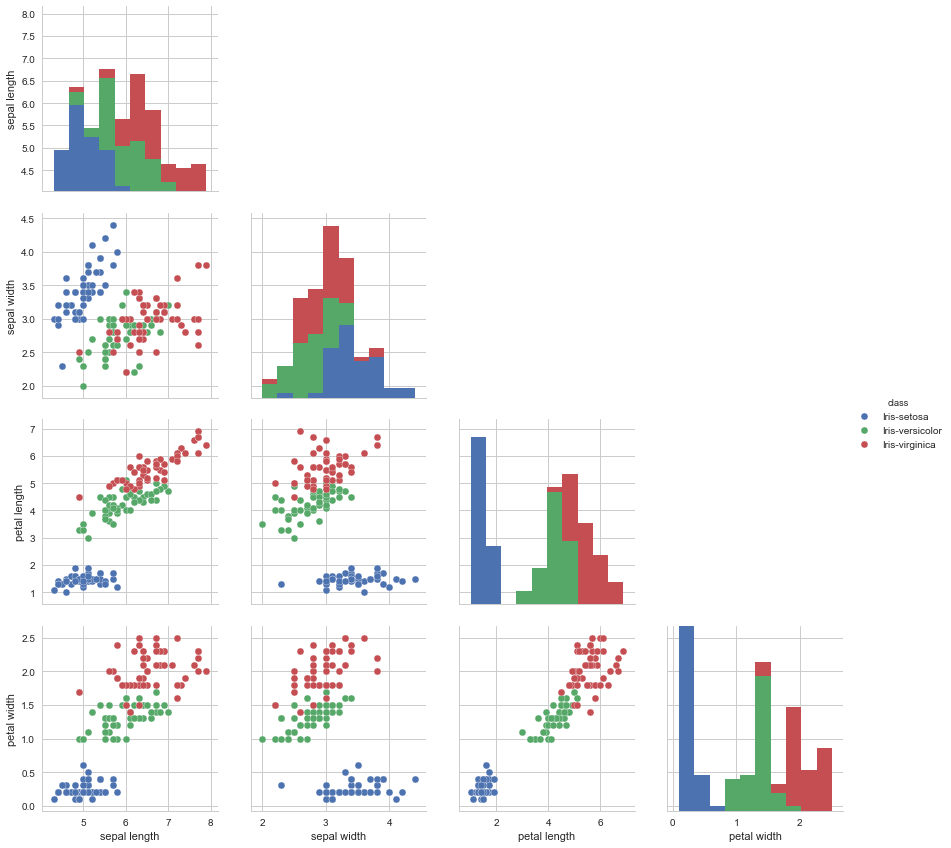

In [3]:
sns.set(style='whitegrid')
g = sns.pairplot(ds, hue="class", size=3)

# Remove o triângulo superior, que apenas espelha o inferior
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].remove()

> Aqui é possível verificar que a **`Iris-setosa`** está separada das demais em todas as combinações de atributos.

## Pré-processamento dos dados

In [4]:
# Mapeia as classes para números
encoder = LabelEncoder()

# Normaliza os atributos para valores entre 0 e 1
scaler = MinMaxScaler()

# Apenas as variáveis X e y serão usadas daqui em diante
X = scaler.fit_transform(ds[header_names[:-1]])
y = encoder.fit_transform(ds['class'])

# Classificadores e intervalos de hiperparâmetros
* Obs: é possível acrescentar novos classificadores e parâmetros nesta seção, sem a necessidade de alterar o resto do código.

In [5]:
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    LogisticRegression()
]

classifier_names = ['K-Nearest Neighbors', 'Support Vector Classifier', 'Logistic Regression']

# Define os valores possíveis dos hiperparâmetros dos classificadores
params = [
    { 'n_neighbors': range(1, 50), 'weights': ['uniform', 'distance'] }, # KNN
    { 'kernel':('linear', 'rbf'), 'C': np.linspace(0.001, 10, 10000) }, # SVC
    { 'C': range(1,1000) } # L. Regression
]

## Otimização de hiperparâmetros

In [6]:
# Os dados são divididos em 3 (33% para validação) randomicamente e de forma balanceada,
# e o processo é repetido 'n_repeats' vezes.
cross_validator = RepeatedStratifiedKFold(n_splits=3, n_repeats=100, random_state=R_STATE)

for classifier, name, param in zip(classifiers, classifier_names, params):
    # Aqui, cada classificador é testado em cross-validation pelo RandomizedSearchCV,
    # para cada combinação randômica dos parâmetros.
    grid = RandomizedSearchCV(classifier, param, scoring='accuracy',
                              cv=cross_validator, random_state=R_STATE).fit(X, y)

    # Seta parâmetros achados no gridsearch
    classifier.set_params(**grid.best_params_)
    
    print('{0}: {1} - {2:.2%}'.format(name, grid.best_params_, grid.best_score_))

K-Nearest Neighbors: {'weights': 'distance', 'n_neighbors': 14} - 95.85%
Support Vector Classifier: {'kernel': 'linear', 'C': 6.0870000000000006} - 96.51%
Logistic Regression: {'C': 929} - 95.62%


> Na busca pelos melhores parâmetros acima, o classificador que obteve melhor desempenho no cross-validation foi o _SVC_, com 96.51% na média de acertos.

# Análise dos classificadores

Com os hiperparâmetros definidos, os classificadores são treinados e testados massivamente, com diferentes combinações da amostra, mas sempre na proporção 66.66% para treinamento e 33.33% para testes.

In [7]:
# Esta função divide os dados randomicamente, na proporção definida por 'n_splits',
# treina os classificadores em cross-validation e repete o processo 'n_repeats' vezes,
# retornando as predições dos conjuntos de teste.
def massive_training(classifiers, X, y, n_splits=3, n_repeats=10):
    y_true = []
    y_preds = [[] for _ in classifiers]
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=R_STATE)
    
    for i_train, i_test in cv.split(X, y):
        X_train, X_test = X[i_train], X[i_test]
        y_train, y_test = y[i_train], y[i_test]

        y_true.extend(y_test)
        for j, classifier in enumerate(classifiers):
            classifier.fit(X_train, y_train)
            y_preds[j].extend(classifier.predict(X_test))
    
    return y_true, y_preds

y_true, y_preds = massive_training(classifiers, X, y, n_repeats=1000)

## Matrizes de confusão

In [8]:
cms = []
for y_pred, name in zip(y_preds, classifier_names):
    matrix = cls_metrics.confusion_matrix(y_true, y_pred)
    cms.append(utils.ConfusionMatrix(matrix, name, encoder.classes_))

### Por classificador

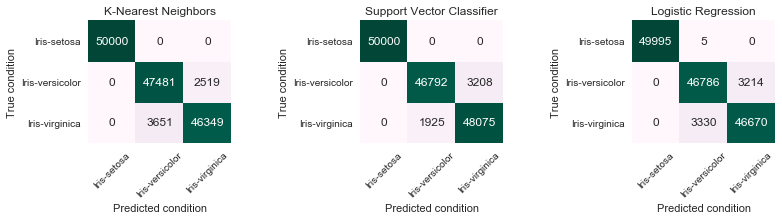

In [9]:
utils.plot_confusion_matrices(cms, cmap='PuBuGn')

> Aqui é possível identificar que a classe **`Iris-setosa`** alcança os valores máximos em todas as métricas para os dois primeiros classificadores, e chega muito próximo disso no terceiro.

### Por classe

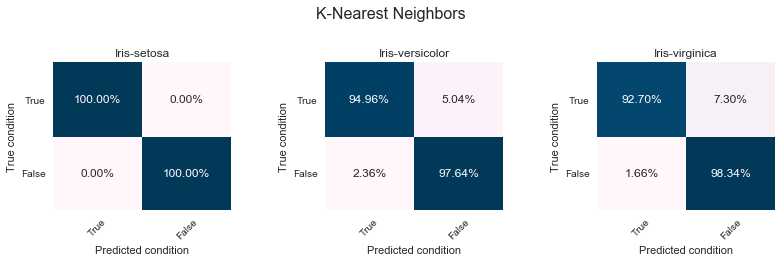

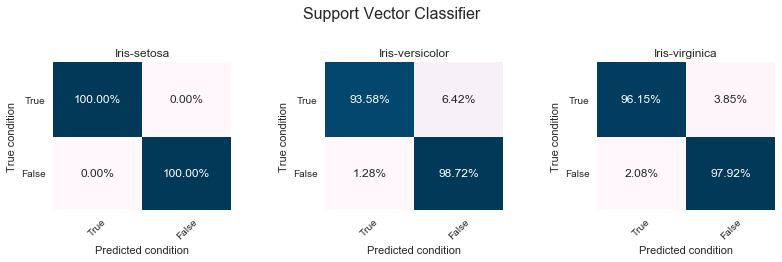

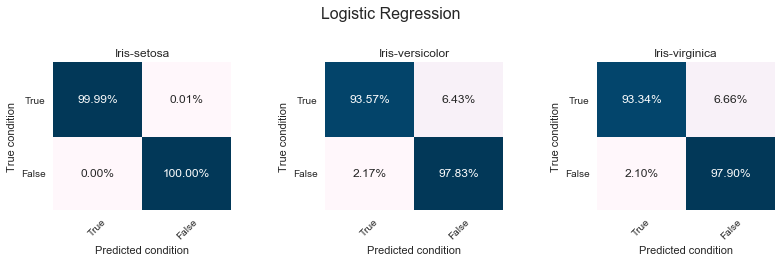

In [10]:
for cm in cms:
    utils.plot_confusion_matrices(cm, percentage=True)

Os percentuais aqui já indicam algumas métricas:
***
* **`[0,0] True positive rate (Sensitivity)`**
* **`[0,1] False negative rate`**
* **`[1,0] False positive rate`**
* **`[1,1] True negative rate (Specificity)`**
***

## Métricas

* Obs: basta descomentar as métricas para que apareçam nas tabelas.

In [11]:
columns = ['Classifier', 'Class', 'Description', 'Acronym', 'Value']
rows = []
for cm in cms:
    for cl in cm:
        for m in cl.metrics:
            rows.append((cm.name, cl.name, *m))

metric_types = [
  'TPR', # Sensitivity, recall, hit rate, or true positive rate
  'TNR', # Specificity or true negative rate
  'PPV', # Precision or positive predictive value
  'NPV', # Negative predictive value
#  'FPR', # Fall-out or false positive rate
#  'FDR', # False discovery rate
#  'FNR', # Miss rate or false negative rate
  'ACC', # Accuracy
#  'F1',  # F1 score - is the harmonic mean of precision and sensitivity
#  'MCC', # Matthews correlation coefficient
#  'BM',  # Informedness or Bookmaker Informedness
#  'MK',  # Markedness
]

metrics = pd.DataFrame(rows, columns=columns)

### Por classificador
Os valores das métricas por classificador são referentes a média das mesmas para cada uma das classes.

In [12]:
metrics[metrics.Acronym.isin(metric_types)].\
    pivot_table(index=['Description', 'Acronym'],
                columns=['Classifier'], values='Value', aggfunc='mean').\
    style.format("{:.2%}").highlight_max(axis=1)

> O SVC possui as melhores médias das métricas.

### Por classe

In [13]:
m = metrics[metrics.Acronym.isin(metric_types)].\
    pivot_table(index=['Description', 'Acronym'],
                columns=['Class', 'Classifier'], values='Value')

for cl in encoder.classes_:
    display(m[[cl]].style.format("{:.2%}").highlight_max(axis=1))

# Conclusão

No geral, classificador que apresentou melhores resultados foi o **Suport Vector Classifier**. Abaixo está um resumo dos resultados por classe.

***
* **`Iris-setosa`**: É possível notar que todos os classificadores desempenharam perfeitamente em todas as 50 mil predições. Houveram 5 falsos negativos em `LgR`, mas nenhum falso positivo. Ou seja, os três classificadores garantem *especificidade* e *precisão* máximas para essa classe. A *sensibilidade* também pode ser considerada máxima para todos, se descartados os 5 falsos negativos de `LgR`.

* **`Iris-versicolor`**: Para essa classe, temos um impasse. Apesar de aparentemente o classificador `KNN` ter acertado uma quantidade maior, ele também obteve a maior quantidade de falsos positivos. Ou seja, foi o que obteve menor *precisão*: 92.86%. Nesse aspecto, `SVC` teve melhor desempenho, com precisão de 96.05%.

* **`Iris-virginica`**: Novamente os classificadores `SVC` e `KNN` possuem os melhores resultados, porém o `SVC` é ligeiramente melhor na maioria das métricas, só perdendo para o `KNN` na *especificidade* e *precisão*, mas ambas com uma diferença menor do que 1%.

***

## Futuras melhorias

* Como parece fácil identificar a **Iris-setosa**, pode-se dar um peso maior para as classes remanescentes na busca por classificadores e hiperparâmetros.